In [1]:
import math, os, torch, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from datasets import load_dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer, GPT2Config, GPT2LMHeadModel

sns.set_style("whitegrid")
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


e:\Research\LLM_Smashdown_Vega\my_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [7]:
# -------------------- 1. Config --------------------
ROOT          = Path(".")         # project root
RES           = ROOT / "results"              # where .pt checkpoints live
STUDENT_LAYERS = [4, 5, 6, 7, 8]              # which checkpoints to test
BATCH_SIZE    = 8                             # eval micro-batch
SUBSET_LINES  = 1_000                         # None → full test split
KL_TEMP       = 1.0                           # temperature used in KL
MAX_LEN       = 128                           # must match training


In [8]:
# -------------------- 2. Teacher model --------------------
teacher_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(teacher_name)
tokenizer.pad_token = tokenizer.eos_token   # ensure pad token is set
teacher = AutoModelForCausalLM.from_pretrained(teacher_name).to(device).eval()

print(f"Teacher loaded: {teacher_name} | layers = {teacher.config.n_layer}")


Teacher loaded: distilgpt2 | layers = 6


In [9]:
# -------------------- 3. Dataset --------------------
test_ds = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
if SUBSET_LINES is not None:
    test_ds = test_ds.select(range(min(SUBSET_LINES, len(test_ds))))
print("Eval lines:", len(test_ds))

def tok_fn(ex):
    return tokenizer(ex["text"], truncation=True, padding="max_length", max_length=MAX_LEN)
test_tok = test_ds.map(tok_fn, batched=True)
test_tok.set_format(type="torch", columns=["input_ids", "attention_mask"])
test_loader = DataLoader(test_tok, batch_size=BATCH_SIZE)



Eval lines: 1000


In [10]:
# -------------------- 4. Helpers --------------------
@torch.no_grad()
def tokenwise_nll(model, dl):
    total_loss, total_tokens = 0.0, 0
    for batch in dl:
        batch = {k: v.to(device) for k, v in batch.items()}
        out = model(**batch, labels=batch["input_ids"])
        total_loss  += out.loss.item() * batch["input_ids"].numel()
        total_tokens += batch["input_ids"].numel()
    return total_loss / total_tokens     # mean NLL per token

@torch.no_grad()
def kl_to_teacher(student, teacher, dl, T=1.0):
    tot, tot_tok = 0.0, 0
    for batch in dl:
        batch = {k: v.to(device) for k, v in batch.items()}
        t = teacher(**batch).logits / T
        s = student(**batch).logits  / T
        kl = F.kl_div(F.log_softmax(s, dim=-1), F.softmax(t, dim=-1), reduction="batchmean")
        tot += kl.item() * batch["input_ids"].numel()
        tot_tok += batch["input_ids"].numel()
    return tot / tot_tok                 # mean KL per token

def load_student(layers: int):
    """Build a student skeleton & load weights from results/student_model_{layers}.pt"""
    ckpt = RES / f"student_model_{layers}.pt"
    if not ckpt.exists():
        raise FileNotFoundError(ckpt)
    cfg = GPT2Config(
        vocab_size = tokenizer.vocab_size,
        n_positions = MAX_LEN,
        n_ctx       = MAX_LEN,
        n_embd      = teacher.config.n_embd,
        n_layer     = layers,
        n_head      = teacher.config.n_head
    )
    stud = GPT2LMHeadModel(cfg)
    with torch.no_grad():
        stud.transformer.wte.weight.copy_(teacher.transformer.wte.weight)
        stud.lm_head.weight.copy_(teacher.lm_head.weight)
    stud.load_state_dict(torch.load(ckpt, map_location="cpu"))
    return stud.to(device).eval()



In [11]:
# -------------------- 5. Main loop --------------------
rows = []

# teacher first
t_nll = tokenwise_nll(teacher, test_loader)
rows.append(dict(Model="Teacher", Layers=teacher.config.n_layer,
                 NLL=t_nll, Perplexity=math.exp(t_nll), KL=0.0))

# each student
for L in STUDENT_LAYERS:
    stud = load_student(L)
    s_nll = tokenwise_nll(stud, test_loader)
    s_kl  = kl_to_teacher(stud, teacher, test_loader, T=KL_TEMP)
    rows.append(dict(Model=f"Student_{L}", Layers=L,
                     NLL=s_nll, Perplexity=math.exp(s_nll), KL=s_kl))
    del stud; torch.cuda.empty_cache()

df = pd.DataFrame(rows).sort_values("Layers").reset_index(drop=True)
df



Model  Layers       NLL   Perplexity         KL
0  Student_4       4  7.607615  2013.470612  19.256749
1  Student_5       5  7.592086  1982.443839  17.315876
2    Teacher       6  7.509718  1825.698119   0.000000
3  Student_6       6  7.580443  1959.496548  15.658727
4  Student_7       7  7.561503  1922.733039  14.367247
5  Student_8       8  7.570491  1940.092302  13.922844

C:\Users\gharamik\AppData\Local\Temp\ipykernel_23196\170089538.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df, x="Layers", y="Perplexity", marker="o", palette=palette)


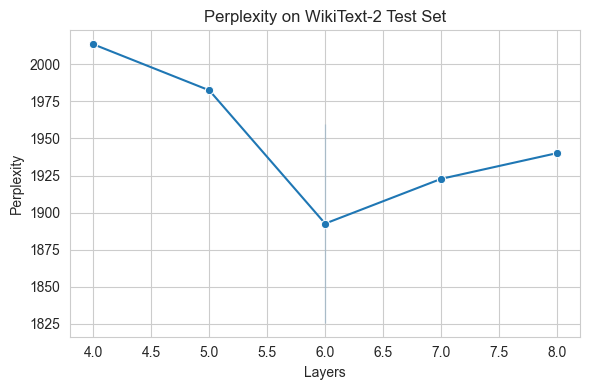

C:\Users\gharamik\AppData\Local\Temp\ipykernel_23196\170089538.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df, x="Layers", y="KL", marker="o", palette=palette)


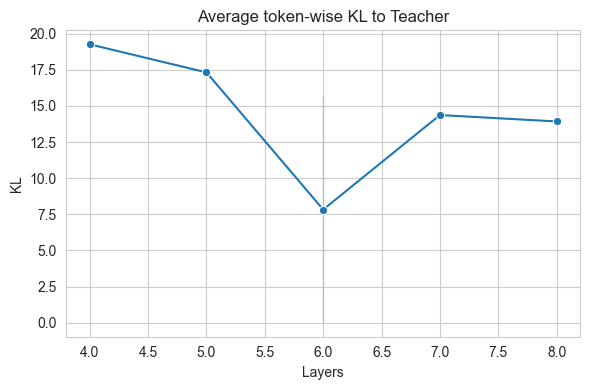

In [12]:
# -------------------- 6. Viz --------------------
palette = sns.color_palette("crest", len(df))

# Perplexity vs layers
plt.figure(figsize=(6,4))
sns.lineplot(data=df, x="Layers", y="Perplexity", marker="o", palette=palette)
plt.title("Perplexity on WikiText-2 Test Set")
plt.tight_layout()
plt.show()

# KL divergence vs layers
plt.figure(figsize=(6,4))
sns.lineplot(data=df, x="Layers", y="KL", marker="o", palette=palette)
plt.title("Average token-wise KL to Teacher")
plt.tight_layout()
plt.show()


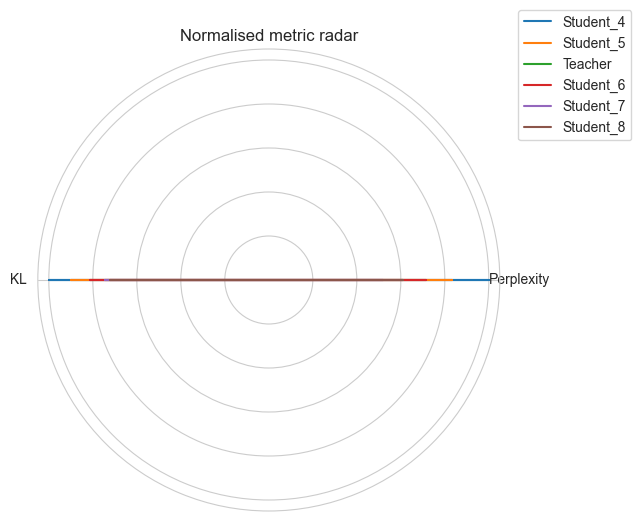

In [13]:
# Radar chart of multiple metrics
import numpy as np
def radar_chart(df, metrics=("Perplexity", "KL")):
    labels = list(metrics)
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6,6), subplot_kw={"polar":True})
    for _, row in df.iterrows():
        values = [row[m] for m in labels]
        values = [(v-min(df[m]))/(max(df[m])-min(df[m])+1e-9) for v,m in zip(values,labels)]  # normalise 0-1
        values += values[:1]
        ax.plot(angles, values, label=row["Model"])
        ax.fill(angles, values, alpha=0.1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_yticklabels([])
    ax.set_title("Normalised metric radar")
    ax.legend(loc="upper right", bbox_to_anchor=(1.3,1.1))
radar_chart(df)
plt.show()


## Extra Dataset (wikitest-103) Evaluation

In [14]:
# ---------------------------------------------------------
# 1.  Extra dataset = WikiText-103   (only evaluation)
# ---------------------------------------------------------
from datasets import load_dataset

WT103_LINES = 2_000          # change as you like (None = full split)

wt103 = load_dataset("wikitext", "wikitext-103-raw-v1",
                     split="test")          # the held-out split
if WT103_LINES:
    wt103 = wt103.select(range(WT103_LINES))

def tok_fn_103(ex):
    return tokenizer(ex["text"], truncation=True,
                     padding="max_length", max_length=MAX_LEN)
wt103_tok = wt103.map(tok_fn_103, batched=True)
wt103_tok.set_format(type="torch", columns=["input_ids", "attention_mask"])
wt103_loader = DataLoader(wt103_tok, batch_size=BATCH_SIZE)

def eval_on_loader(model):
    nll = tokenwise_nll(model, wt103_loader)
    ppl = math.exp(nll)
    return nll, ppl


e:\Research\LLM_Smashdown_Vega\my_env\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\gharamik\.cache\huggingface\hub\datasets--wikitext. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Map: 100%|██████████| 2000/2000 [00:00<00:00, 13236.52 examples/s]


In [15]:
rows_103 = []

t_nll, t_ppl = eval_on_loader(teacher)
rows_103.append(dict(Dataset="WT103", Model="Teacher",
                     Layers=teacher.config.n_layer,
                     NLL=t_nll, Perplexity=t_ppl, KL=0.0))

for L in STUDENT_LAYERS:
    stud = load_student(L)
    nll, ppl = eval_on_loader(stud)
    kl      = kl_to_teacher(stud, teacher, wt103_loader, T=KL_TEMP)
    rows_103.append(dict(Dataset="WT103", Model=f"Student_{L}",
                         Layers=L, NLL=nll, Perplexity=ppl, KL=kl))
    del stud; torch.cuda.empty_cache()

df_103 = pd.DataFrame(rows_103).sort_values("Layers")
df_103


Dataset      Model  Layers       NLL   Perplexity         KL
1   WT103  Student_4       4  7.615627  2029.667102  18.997224
2   WT103  Student_5       5  7.597548  1993.301759  17.263323
0   WT103    Teacher       6  7.515951  1837.114183   0.000000
3   WT103  Student_6       6  7.589648  1977.617709  15.575295
4   WT103  Student_7       7  7.569902  1938.950537  14.376094
5   WT103  Student_8       8  7.575714  1950.252444  13.838641

C:\Users\gharamik\AppData\Local\Temp\ipykernel_23196\2551145871.py:45: RuntimeWarning: invalid value encountered in divide
  return tot / cnt


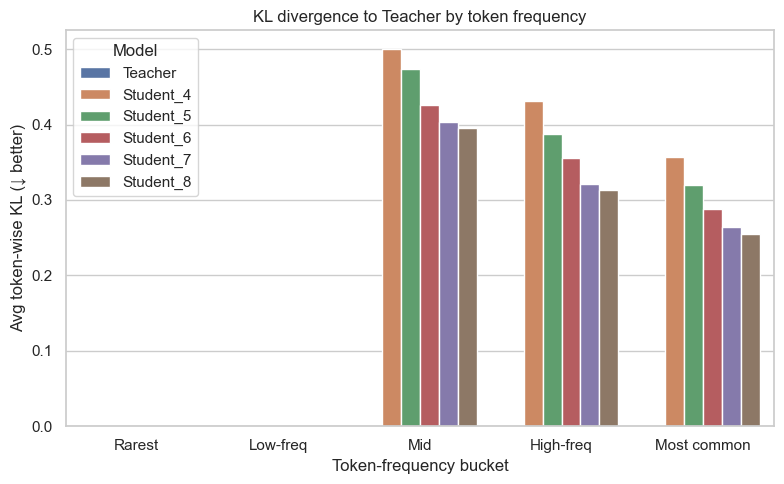

Bucket     High-freq  Low-freq    Mid  Most common  Rarest
Model                                                     
Student_4      0.431       NaN  0.500        0.357     NaN
Student_5      0.387       NaN  0.473        0.319     NaN
Student_6      0.356       NaN  0.426        0.288     NaN
Student_7      0.321       NaN  0.403        0.264     NaN
Student_8      0.313       NaN  0.395        0.255     NaN
Teacher        0.000       0.0  0.000        0.000     0.0

In [18]:
# ---------------------------------------------------------
# 2.  Bucket KL divergence by token frequency
#     Token-frequency bucket KL (rare vs common tokens)
# ---------------------------------------------------------
import torch, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from collections import Counter
from tqdm.auto import tqdm

# 1️⃣ build frequency buckets on WikiText-2 test set
def build_freq_buckets(ds, n_buckets=5):
    counts = Counter()
    for ids in ds["input_ids"]:
        counts.update(ids.tolist() if isinstance(ids, torch.Tensor) else ids)
    total  = sum(counts.values())
    freqs  = {tok: c / total for tok, c in counts.items()}
    qs     = np.quantile(list(freqs.values()), np.linspace(0,1,n_buckets+1))
    def bucket_id(p): return min(np.searchsorted(qs, p, side="right")-1, n_buckets-1)
    return {tok: bucket_id(p) for tok, p in freqs.items()}

freq_map = build_freq_buckets(test_tok, n_buckets=5)
labels   = ["Rarest", "Low-freq", "Mid", "High-freq", "Most common"]

# 2️⃣ helper: bucket-wise KL for one model
@torch.no_grad()
def bucket_kl(student, teacher, loader, mapping, nbuckets=5, T=1.0, pad_id=None):
    tot = np.zeros(nbuckets); cnt = np.zeros(nbuckets)
    for batch in tqdm(loader, leave=False):
        batch = {k:v.to(device) for k,v in batch.items()}
        # logits → softmax with temperature, stay in fp32 for stability
        t = teacher(**batch).logits.float() / T
        s = student (**batch).logits.float() / T
        kl_token = torch.nn.functional.kl_div(
                       torch.log_softmax(s, dim=-1),
                       torch.softmax(t, dim=-1),
                       reduction="none").sum(-1)          # [B, L]
        ids = batch["input_ids"]                         # [B, L]
        for row_ids, row_kl in zip(ids, kl_token):
            for tok_id, kl_val in zip(row_ids, row_kl):
                if pad_id is not None and tok_id.item() == pad_id:
                    continue                             # skip padding
                b = mapping.get(int(tok_id), 0)
                tot[b] += kl_val.item()
                cnt[b] += 1
    return tot / cnt

# 3️⃣ collect results for teacher + every student
bucket_results = []
bucket_results.append(pd.DataFrame({
    "Model": ["Teacher"]*5, "Bucket": labels, "KL": np.zeros(5)
}))

pad_id = tokenizer.pad_token_id
for L in STUDENT_LAYERS:
    stu = load_student(L)
    kl_vals = bucket_kl(stu, teacher, test_loader,
                        mapping=freq_map, nbuckets=5,
                        T=KL_TEMP, pad_id=pad_id)
    bucket_results.append(pd.DataFrame({
        "Model": [f"Student_{L}"]*5,
        "Bucket": labels,
        "KL": kl_vals
    }))
    del stu; torch.cuda.empty_cache()

df_buckets = pd.concat(bucket_results, ignore_index=True)

# 4️⃣ plot
plt.figure(figsize=(8,5))
sns.barplot(data=df_buckets, x="Bucket", y="KL", hue="Model")
plt.ylabel("Avg token-wise KL (↓ better)"); plt.xlabel("Token-frequency bucket")
plt.title("KL divergence to Teacher by token frequency")
plt.tight_layout(); plt.show()

# 5️⃣ numeric table (optional)
display(df_buckets.pivot(index="Model", columns="Bucket", values="KL").round(3))



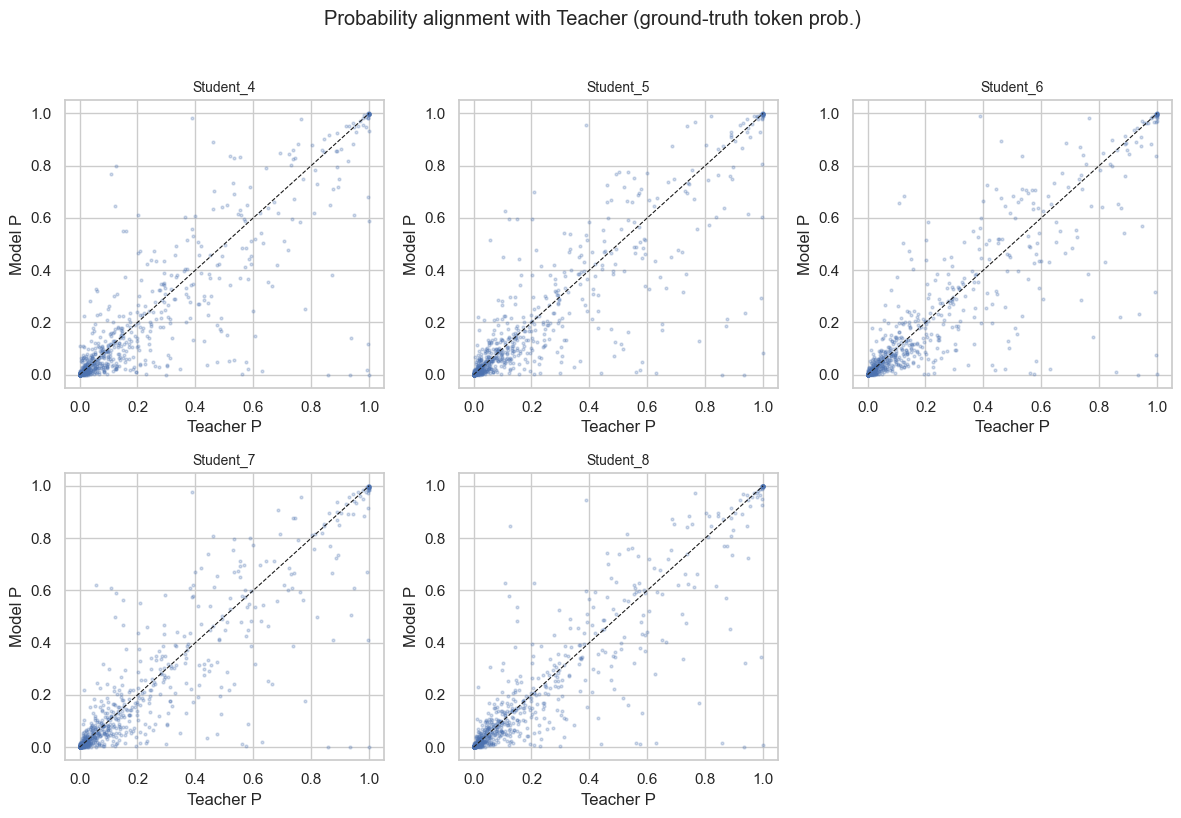

In [19]:
def sample_teacher_probs(batch, teacher_logits):
    """Return tensor [B, L-1] with P_teacher(gt_token | context)."""
    gt = batch["input_ids"][:, 1:]                      # ground-truth next tokens
    probs = torch.softmax(teacher_logits[:,:-1], dim=-1)
    rows = torch.arange(gt.size(0)).unsqueeze(-1)
    cols = torch.arange(gt.size(1)).unsqueeze(0)
    return probs[rows, cols, gt]                       # gather the GT prob

def scatter_one(model, name, ax, max_points=5_000):
    xs, ys = [], []
    with torch.no_grad():
        for batch in test_loader:
            batch = {k:v.to(device) for k,v in batch.items()}
            t_logits = teacher(**batch).logits
            s_logits = model (**batch).logits
            t_p = sample_teacher_probs(batch, t_logits)
            s_p = sample_teacher_probs(batch, s_logits)
            xs.extend(t_p.cpu().flatten().tolist())
            ys.extend(s_p.cpu().flatten().tolist())
            if len(xs) >= max_points:
                break
    xs, ys = xs[:max_points], ys[:max_points]
    ax.scatter(xs, ys, s=4, alpha=.25)
    ax.plot([0,1], [0,1], 'k--', linewidth=.8)
    ax.set_title(name, fontsize=10)
    ax.set_xlabel("Teacher P")
    ax.set_ylabel("Model P")

# ---------- build grid ----------
models_to_plot = [("Student_"+str(L), L) for L in STUDENT_LAYERS]
cols = 3
rows = math.ceil(len(models_to_plot) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
axes = axes.flatten()

for idx, (label, L) in enumerate(models_to_plot):
    stu = load_student(L)
    scatter_one(stu, label, axes[idx])
    del stu; torch.cuda.empty_cache()

# remove unused axes
for j in range(idx+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Probability alignment with Teacher (ground-truth token prob.)", y=1.02)
plt.tight_layout()
plt.show()


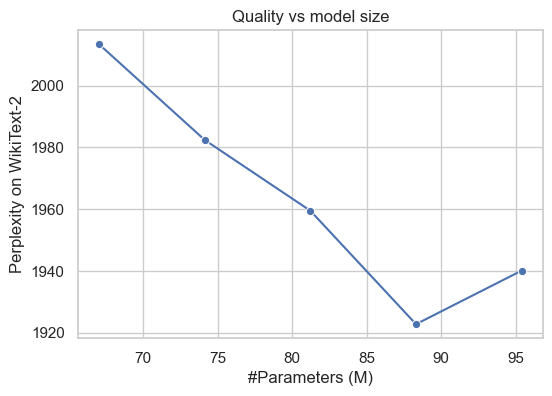

In [20]:
# ---------------------------------------------------------
# 4.  #Parameters vs Perplexity
#      Performance-vs-size cost curve
# ---------------------------------------------------------
def nparams(model): return sum(p.numel() for p in model.parameters())

param_rows = []
for L in STUDENT_LAYERS:
    stud = load_student(L)
    param_rows.append(dict(Layers=L, Params=nparams(stud)/1e6,   # in millions
                           PPL=df.loc[df.Model==f"Student_{L}", "Perplexity"].values[0]))
    del stud

param_df = pd.DataFrame(param_rows)
plt.figure(figsize=(6,4))
sns.lineplot(data=param_df, x="Params", y="PPL", marker="o")
plt.xlabel("#Parameters (M)"); plt.ylabel("Perplexity on WikiText-2")
plt.title("Quality vs model size")
plt.show()



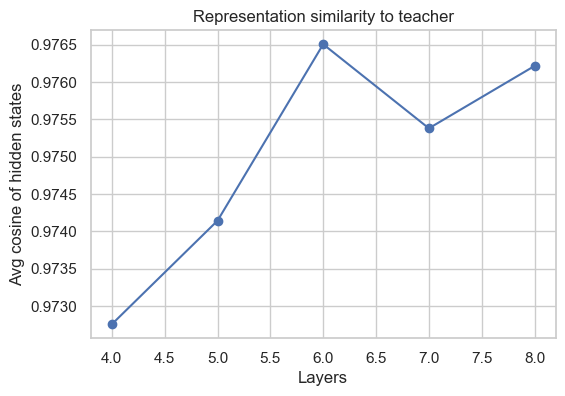

In [21]:
# ---------------------------------------------------------
# 5.  Cosine similarity of final hidden states
#     Simple representation similarity (cosine of last-hidden state)
# ---------------------------------------------------------
@torch.no_grad()
def hidden_cosine(student, teacher, dl, nsent=500):
    cos = torch.nn.CosineSimilarity(-1)
    sims = []
    for batch in dl:
        batch = {k:v.to(device) for k,v in batch.items()}
        t_h = teacher.transformer(**batch).last_hidden_state     # [B, T, H]
        s_h = student .transformer(**batch).last_hidden_state
        sims.extend(cos(t_h, s_h).mean(-1).flatten().cpu().tolist())
        if len(sims) > nsent: break
    return np.mean(sims)

cos_scores = {}
for L in STUDENT_LAYERS:
    cos_scores[L] = hidden_cosine(load_student(L), teacher, test_loader)

plt.figure(figsize=(6,4))
plt.plot(list(cos_scores.keys()), list(cos_scores.values()), marker="o")
plt.xlabel("Layers"); plt.ylabel("Avg cosine of hidden states")
plt.title("Representation similarity to teacher")
plt.show()


## More Evaluations
from `Scalable Extraction of Training Data from (Production) Language Models` Paper


In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import torch, random
from collections import Counter, defaultdict
from tqdm.auto import tqdm
from datasets import load_dataset


plt.rcParams.update({
    "figure.figsize": (7,4.2),
    "axes.spines.top": False,
    "axes.spines.right": False,
})

device = "cuda" if torch.cuda.is_available() else "cpu"

# ----- parameters -----
N_PROMPTS   = 2_000       # how many prompts to sample
PROMPT_LEN  = 30          # tokens fed to teacher/student
GEN_LEN     = 40          # tokens to generate
K           = 20          # k-gram length (20 for quick demo)

# ----- choose a dataset as prompt source -----
prompt_ds   = load_dataset("wikitext", "wikitext-2-raw-v1", split="train") \
                .select(range(N_PROMPTS))




In [28]:
def tokenise(text):
    return tokenizer(text, add_special_tokens=False).input_ids

prompts_tok = [tokenise(r["text"])[:PROMPT_LEN] or [tokenizer.eos_token_id]
               for r in prompt_ds]

# helper to extract overlapping k-grams from a list of token ids
def kgrams(seq, k=K):
    return [tuple(seq[i:i+k]) for i in range(len(seq)-k+1)]

# storage
extracted = defaultdict(list)   # model → list of k-grams (with repeats)
stats = {}                      # model → DataFrame(row-wise totals)

# ------------------------------------------------------------
# Revised run_model that tracks unique-kgram count per k-gram
# ------------------------------------------------------------
def run_model(model, name):
    model.eval()
    grams   = []          # all extracted k-grams
    uniques = []          # running #unique after each add

    with torch.no_grad():
        for p in tqdm(prompts_tok, desc=name):
            prompt = torch.tensor([p]).to(device)
            out    = model.generate(prompt,
                                    max_length=PROMPT_LEN + GEN_LEN,
                                    do_sample=False)   # greedy
            gen = out[0, PROMPT_LEN:].tolist()

            for kg in kgrams(gen, K):        # update *per* k-gram
                grams.append(kg)
                uniques.append(len(set(grams)))

    extracted[name] = grams
    stats[name] = pd.DataFrame({
        "total":  np.arange(1, len(grams) + 1),
        "unique": uniques                 # same length as total
    })

# ---------- run teacher + students ----------
run_model(teacher, "Teacher")
for L in STUDENT_LAYERS:
    run_model(load_student(L), f"Student_{L}")
    torch.cuda.empty_cache()
    

Teacher:   0%|          | 0/2000 [00:00<?, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Teacher:   0%|          | 1/2000 [00:00<21:17,  1.56it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Teacher:   0%|          | 2/2000 [00:00<14:32,  2.29it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Teacher:   0%|          | 3/2000 [00:01<13:01,  2.55it/s]The attention mask and the 

In [29]:
# train_text  = load_dataset("wikitext","wikitext-2-raw-v1", split="train")
# train_counts = Counter()

# for rec in tqdm(train_text, desc="scan k-grams in training"):
#     toks = tokenise(rec["text"])
#     train_counts.update(kgrams(toks, K))


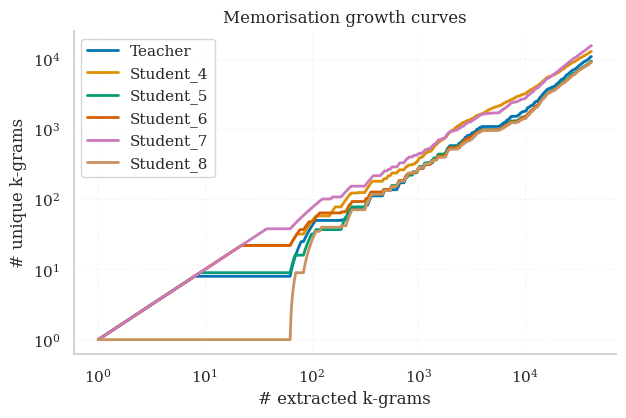

In [30]:
# Cell 3 – Plot running unique-k-gram curves
def memorisation_curve(df, label, ax=None):
    ax = ax or plt.gca()
    ax.plot(df["total"], df["unique"], lw=2, label=label)
    ax.set_xscale("log"); ax.set_yscale("log")

fig, ax = plt.subplots()
for key, df in stats.items():
    memorisation_curve(df, key, ax)
ax.set_xlabel("# extracted k-grams"); ax.set_ylabel("# unique k-grams")
ax.set_title("Memorisation growth curves")
ax.legend(); plt.show()


In [31]:
# Cell 4 – Good-Turing tail estimate (Student-6 as example)
from scipy.stats import poisson

def good_turing_tail(counter):
    N_r = Counter(counter.values())
    N_tokens = sum(r * c for r, c in N_r.items())
    p0 = N_r[1] / N_tokens                   # prob(new type on next draw)
    return p0

counter_20g = Counter(extracted["Student_6"])
p0 = good_turing_tail(counter_20g)
expected_new = int(p0 * 100_000)            # next 100k generations
print(f"≈ {expected_new} new unique {K}-grams still hidden "
      f"after 100 k extra queries.")


≈ 19269 new unique 20-grams still hidden after 100 k extra queries.


In [32]:
# Cell 5 – k-gram counts in *training* data
train_counts = Counter()
for rec in tqdm(prompt_ds, desc="scan k-grams in train"):
    train_counts.update(kgrams(tokenise(rec["text"])))


scan k-grams in train: 100%|██████████| 2000/2000 [00:00<00:00, 2117.32it/s]


C:\Users\gharamik\AppData\Local\Temp\ipykernel_23196\124760800.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby("bucket")["hit"].mean()*100


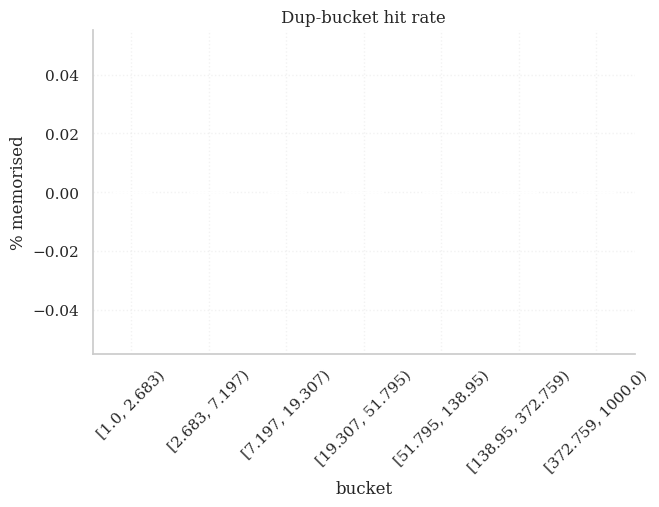

In [33]:
# Cell 6 – Hit-rate vs duplication
def duplication_hit(train_counter, extracted_set,
                    buckets=np.logspace(0,3,8)):
    df = pd.DataFrame({
        "dup": list(train_counter.values()),
        "hit": [k in extracted_set for k in train_counter]
    })
    df["bucket"] = pd.cut(df["dup"], buckets, right=False)
    return df.groupby("bucket")["hit"].mean()*100

hit = duplication_hit(train_counts, set(extracted["Student_6"]))
hit.plot.bar(rot=45); plt.ylabel("% memorised"); plt.title("Dup-bucket hit rate")
plt.show()


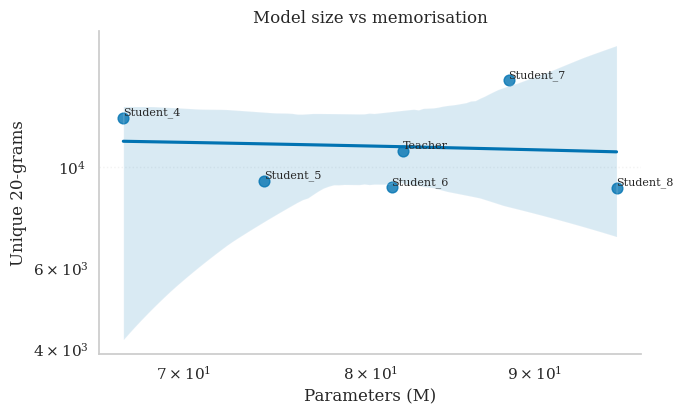

In [34]:
# Cell 7 – Params vs unique k-grams
def nparams(m): return sum(p.numel() for p in m.parameters())/1e6

rows = []
rows.append(dict(model="Teacher",
                 params=nparams(teacher),
                 uniq=len(set(extracted["Teacher"]))))
for L in STUDENT_LAYERS:
    rows.append(dict(model=f"Student_{L}",
                     params=nparams(load_student(L)),
                     uniq=len(set(extracted[f"Student_{L}"]))))

df_size = pd.DataFrame(rows)
sns.regplot(data=df_size, x="params", y="uniq",
            scatter_kws=dict(s=60, alpha=.8))
for _, r in df_size.iterrows():
    plt.text(r.params, r.uniq, r.model, fontsize=8, ha="left", va="bottom")
plt.xscale("log"); plt.yscale("log")
plt.xlabel("Parameters (M)"); plt.ylabel(f"Unique {K}-grams")
plt.title("Model size vs memorisation"); plt.show()
